In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as pl
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from seaborn import heatmap
from matplotlib import rcParams
from cmocean import cm
from theano import tensor as tt
import pickle

In [2]:
% matplotlib inline

In [3]:
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['font.size'] = 16

In [7]:
dfLabels = pd.read_pickle('../PklJar/DFLABELS.pkl')
dfFeatures = pd.read_pickle('../PklJar/DFFEATURES.pkl')

Get rid of data until first recorded stranding (3/7/1999)

In [8]:
dfLabels = dfLabels.loc['1999-03-07':]
dfFeatures = dfFeatures.loc['1999-03-07':]

In [9]:
dfFeatures.head(2)

,Ddelph_count,Lageno_count,FRDH,FRDV,OTTH,OTTV,Kp_index,Sunspot_No,Dst_index,AE_index,...,Pred_med,ampDiff_med,vel_med,move_med,EasterlyWS,SoutherlyWS,WTMP,WVHT,APD,DPD
1999-03-07,0.0,0.0,20973.912083,49185.560903,17437.979625,53532.025069,35.125,65.0,-43.291667,447.416667,...,1.495,0.07,0.005919,2.62,-1.597614,11.183859,2.666667,3.387917,6.39625,8.690000
1999-03-08,0.0,0.0,20990.983472,49181.313264,17456.633064,53532.310625,24.625,62.0,-26.375000,257.083333,...,1.490,0.08,0.007038,2.42,-10.374381,7.568804,2.416667,2.469167,5.68000,9.164583


In [10]:
dfFeatures.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5779 entries, 1999-03-07 to 2014-12-31
Freq: D
Data columns (total 34 columns):
Ddelph_count           5779 non-null float64
Lageno_count           5779 non-null float64
FRDH                   5771 non-null float64
FRDV                   5759 non-null float64
OTTH                   5414 non-null float64
OTTV                   5400 non-null float64
Kp_index               5779 non-null float64
Sunspot_No             5779 non-null float64
Dst_index              5779 non-null float64
AE_index               5779 non-null float64
Proton_flux_gt30MeV    5287 non-null float64
Proton_flux_gt60MeV    5287 non-null float64
Pred_min               5779 non-null float64
ampDiff_min            5779 non-null float64
vel_min                5779 non-null float64
move_min               5779 non-null float64
Pred_max               5779 non-null float64
ampDiff_max            5779 non-null float64
vel_max                5779 non-null float64
move_max    

In [12]:
dfFeatures.drop(['Proton_flux_gt30MeV', 'Proton_flux_gt60MeV'], axis=1, inplace=True)
dfFeatures.drop(['ampDiff_min','vel_min', 'vel_min', 'move_min',
                 'ampDiff_max','vel_max', 'vel_max', 'move_max',
                 'ampDiff_med','vel_med', 'vel_med', 'move_med', 'Pred_med',
                 'ampDiff_std','vel_std', 'vel_std', 'move_std', 'Pred_std'
                ], axis=1, inplace=True)

In [15]:
dfClFeats = dfFeatures.dropna()
dfClLbls = dfLabels.loc[dfClFeats.index,:]
label_list = ['NUM_ANIMALS', 'SPECIES_Delphinus delphis', 'SPECIES_Lagenorhynchus acutus']
X = dfClFeats.as_matrix()
sc = StandardScaler()
X_s = sc.fit_transform(X)
X_all_sp_s = X_s[:,2:]
y_num_obs = dfClLbls.as_matrix(columns=label_list) # don't include species-specific count

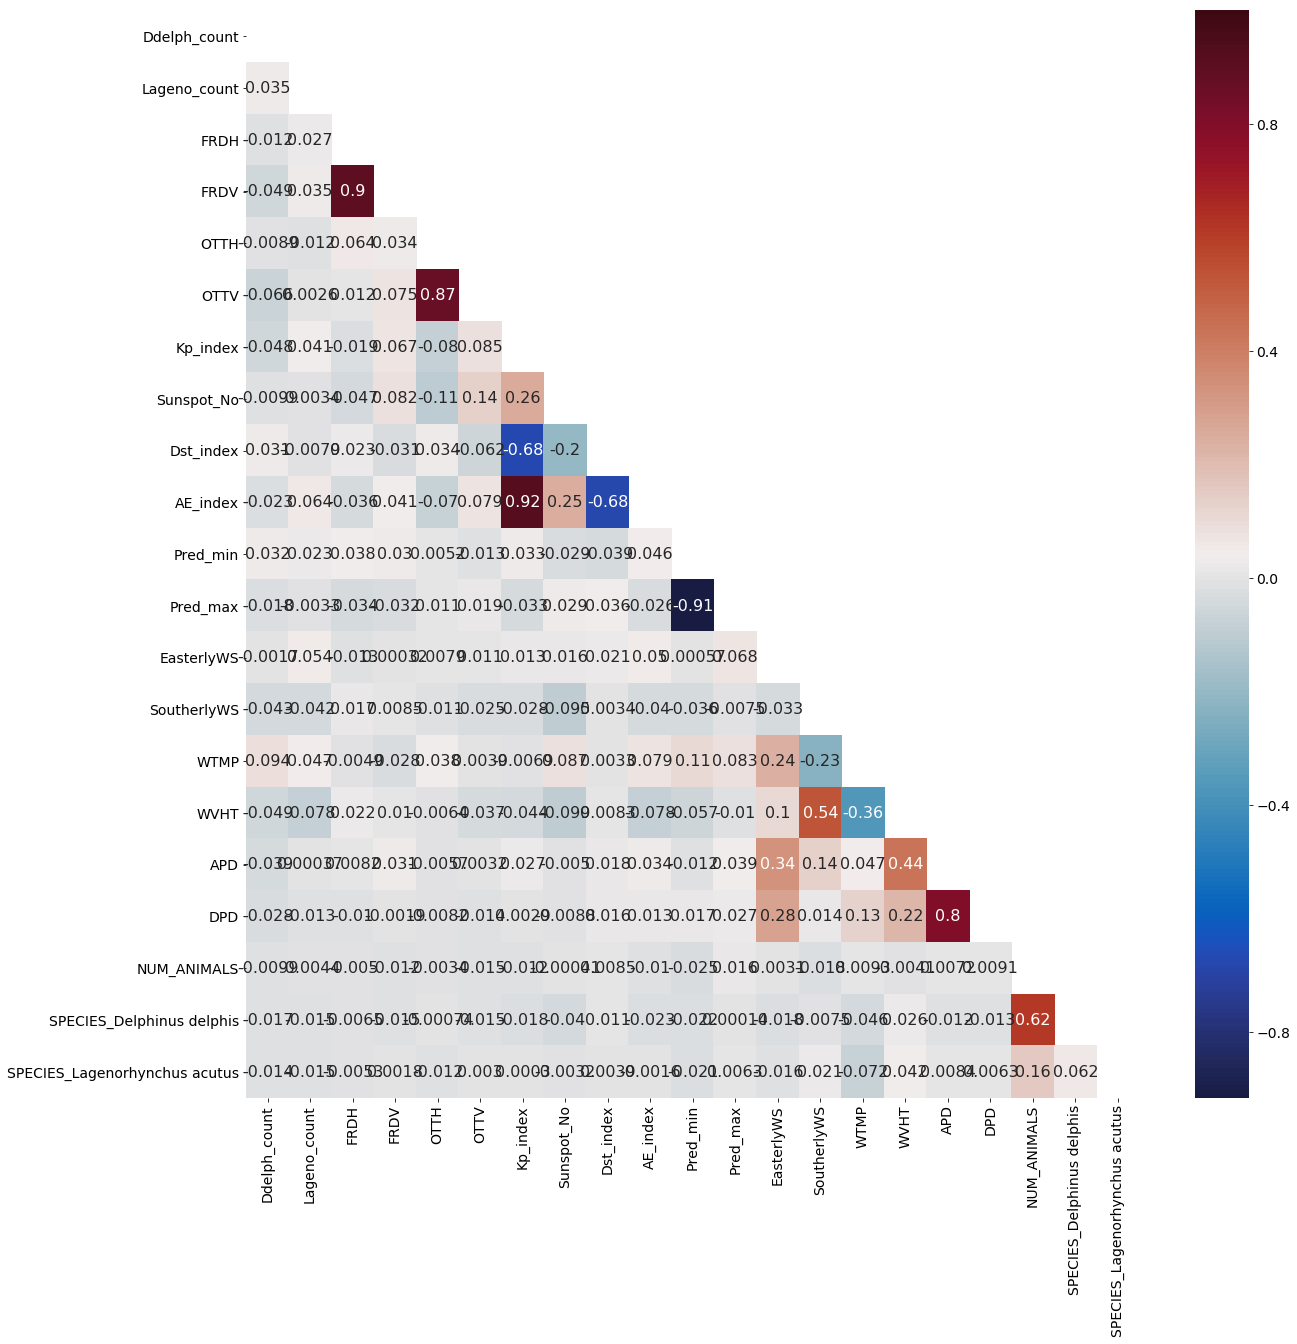

In [16]:
f, ax= pl.subplots(figsize=(20, 20))
heatmap(pd.DataFrame(np.column_stack((X_s, y_num_obs)),
                     columns=dfClFeats.columns.tolist() + label_list).corr(),
        mask=np.triu(np.ones((21,21))),ax=ax, cmap=cm.balance, annot=True)

In [17]:
dfClFeats_decorr = dfClFeats.copy(deep=True)

In [18]:
dfClFeats_decorr['OTT'] = np.sqrt(np.power(dfClFeats.OTTH, 2) + np.power(dfClFeats.OTTV, 2))
dfClFeats_decorr['FRD'] = np.sqrt(np.power(dfClFeats.FRDH, 2) + np.power(dfClFeats.FRDV, 2))

In [19]:
dfClFeats_decorr.drop(['OTTH', 'OTTV', 'FRDH', 'FRDV'], axis=1, inplace=True)

In [20]:
dfClFeats_decorr.drop(['DPD', 'Pred_max', 'AE_index'], axis=1, inplace=True)

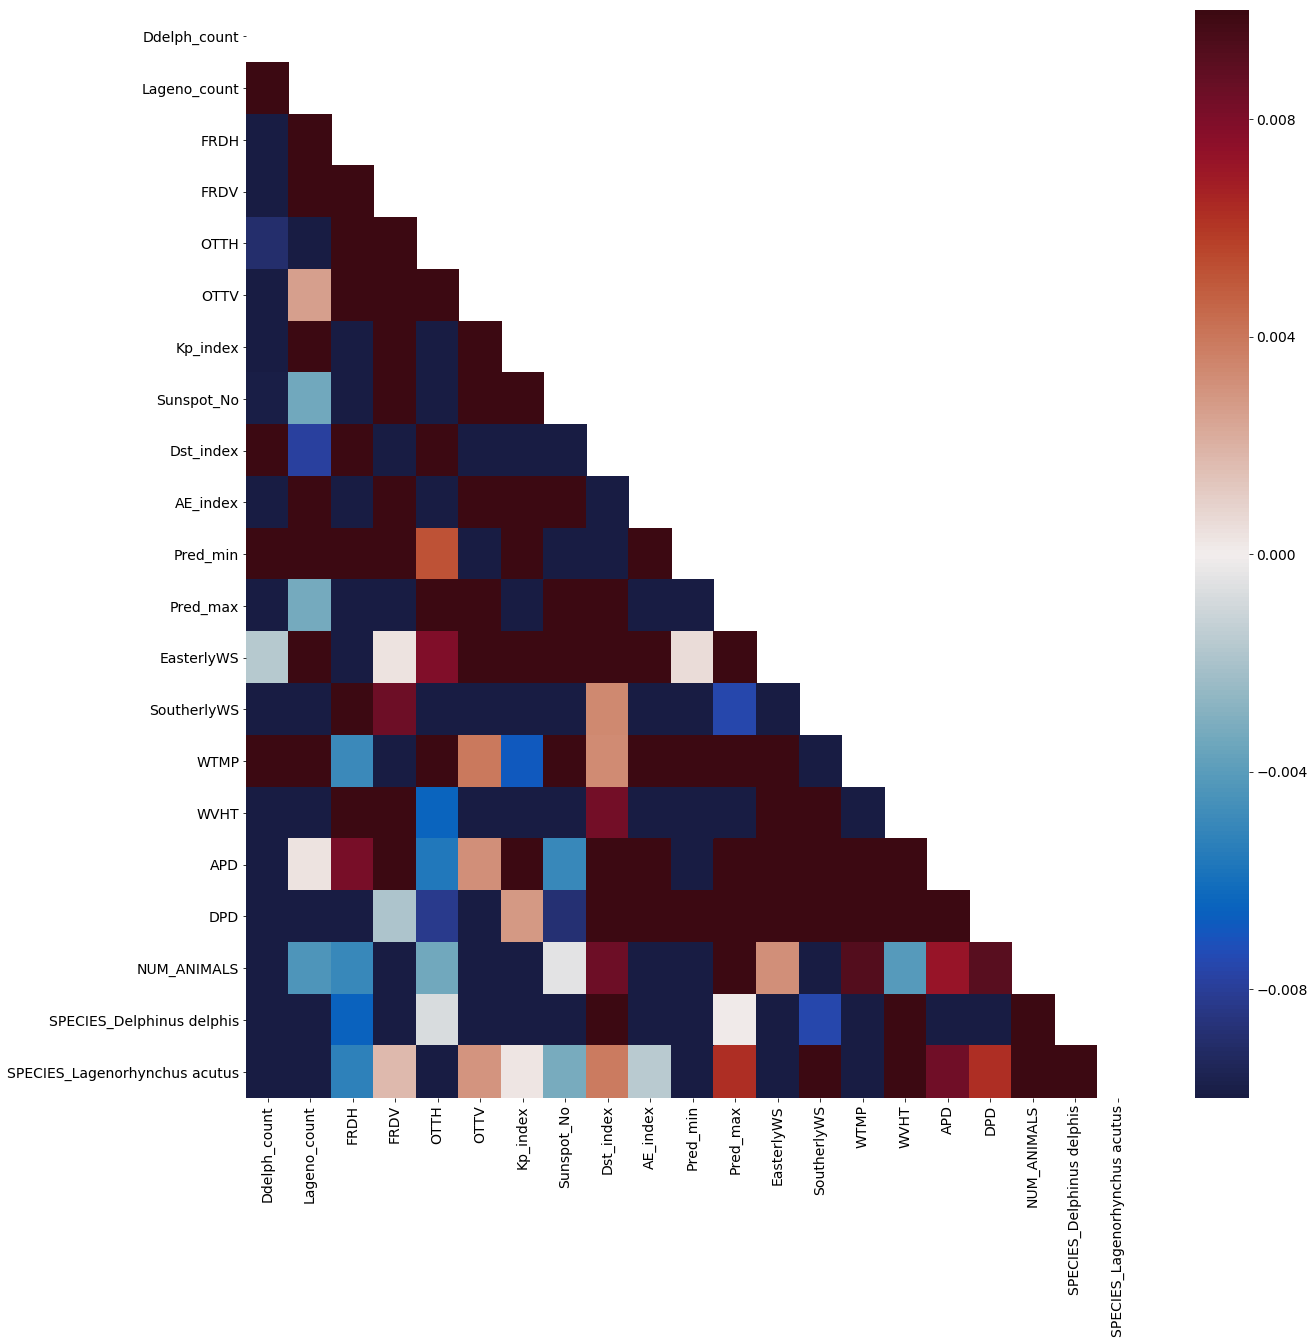

In [21]:
f, ax= pl.subplots(figsize=(20, 20))
heatmap(pd.DataFrame(np.column_stack((X_s, y_num_obs)),
                     columns=dfClFeats.columns.tolist() + label_list).corr(),
        mask=np.triu(np.ones((21,21))),ax=ax, cmap=cm.balance, vmin=-0.01, vmax=0.01, )

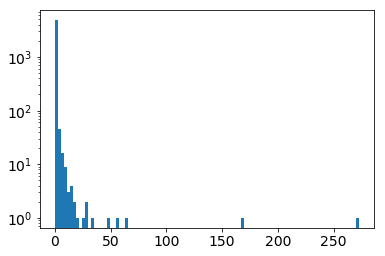

In [22]:
pl.hist(dfClLbls.NUM_ANIMALS, log=True, bins=100);

In [23]:
CleanBayesTrainingSet = {'Features': dfClFeats,
                        'Labels': dfClLbls}
with open('../PklJar/CleanTrainSet.pkl', 'wb') as f:
    pickle.dump(CleanBayesTrainingSet, f)

In [31]:
dfClFeats_decorr.head()

,Ddelph_count,Lageno_count,Kp_index,Sunspot_No,Dst_index,Pred_min,EasterlyWS,SoutherlyWS,WTMP,WVHT,APD,OTT,FRD
1999-03-07,0.0,0.0,35.125,65.0,-43.291667,0.15,-1.597614,11.183859,2.666667,3.387917,6.396250,56300.629139,53470.780707
1999-03-08,0.0,0.0,24.625,62.0,-26.375000,0.24,-10.374381,7.568804,2.416667,2.469167,5.680000,56306.680943,53473.572552
1999-03-09,0.0,0.0,34.500,95.0,-35.833333,0.32,-8.124423,5.416860,2.400000,1.556087,5.028696,56301.094001,53578.909512
1999-03-10,0.0,0.0,38.750,92.0,-44.458333,0.37,-4.053519,2.885376,2.400000,1.031667,5.221667,56274.526795,53461.835296
1999-03-11,0.0,0.0,29.125,114.0,-23.833333,0.38,-7.269797,4.485525,2.358333,1.192500,4.812917,56298.890776,53360.069593


In [24]:
Xdc = dfClFeats_decorr.as_matrix()
scd = StandardScaler()
Xdc_s = scd.fit_transform(Xdc)
Xdc_all_sp_s = Xdc_s[:, 2:] # don't include species-specific count

In [25]:
y_all_obs = dfClLbls.NUM_ANIMALS.values
y_Lag_obs = dfClLbls['SPECIES_Lagenorhynchus acutus'].values
y_Del_obs = dfClLbls['SPECIES_Delphinus delphis'].values

In [26]:
with pm.Model() as m0:
    intercept = pm.Normal('intercept', 0, 100)
    mu = tt.exp(intercept)
    y_pred = pm.Poisson('y_pred', mu=mu, observed=y_all_obs)
    start = pm.find_MAP()
    trace_m0 = pm.sample(10000, start=start)

logp = -8,372.1, ||grad|| = 3,587: 100%|██████████| 8/8 [00:00<00:00, 331.38it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 10500/10500 [00:09<00:00, 1094.79it/s]


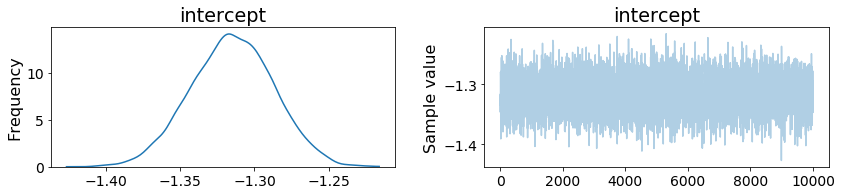

In [27]:
pm.traceplot(trace_m0, figsize=(12, 3));

In [33]:
with pm.Model() as m1:
    intercept = pm.Normal('intercept', 0, 100)
    coefs = pm.Normal('coefs', 0, 100, shape=Xdc_all_sp_s.shape[1])
    mu = tt.exp(pm.math.dot(coefs, Xdc_all_sp_s.T) + intercept)
    y_pred = pm.Poisson('y_pred', mu=mu, observed=y_all_obs)
    start = pm.find_MAP()
    #step = pm.Metropolis()
    trace_m1 = pm.sample(10000, start=start)#, step=step)

logp = -6,079.1, ||grad|| = 2.8892: 100%|██████████| 28/28 [00:00<00:00, 535.26it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 10500/10500 [01:12<00:00, 145.44it/s]


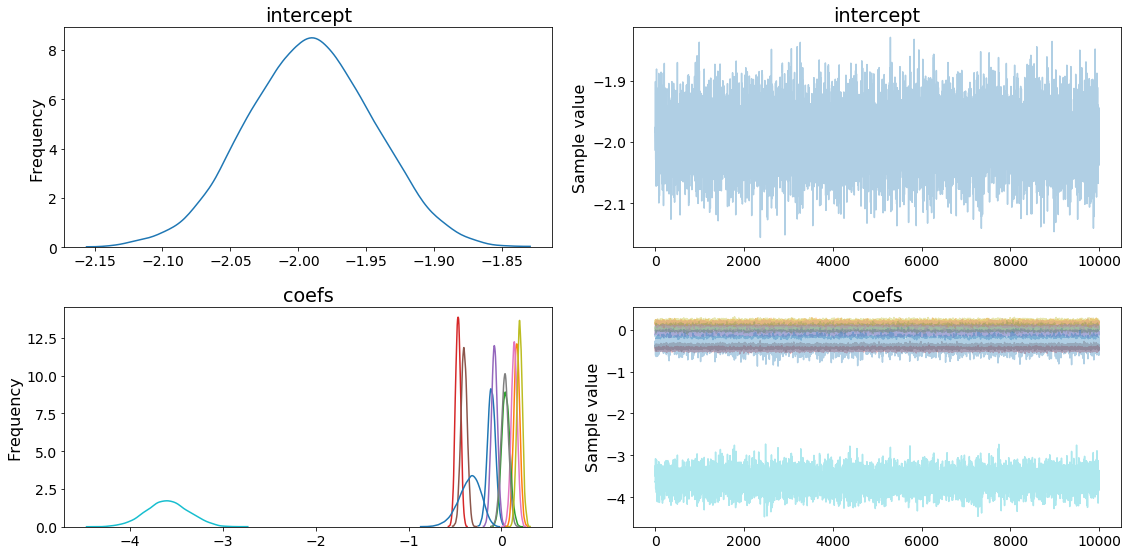

In [34]:
pm.traceplot(trace_m1, figsize=(16, 8));

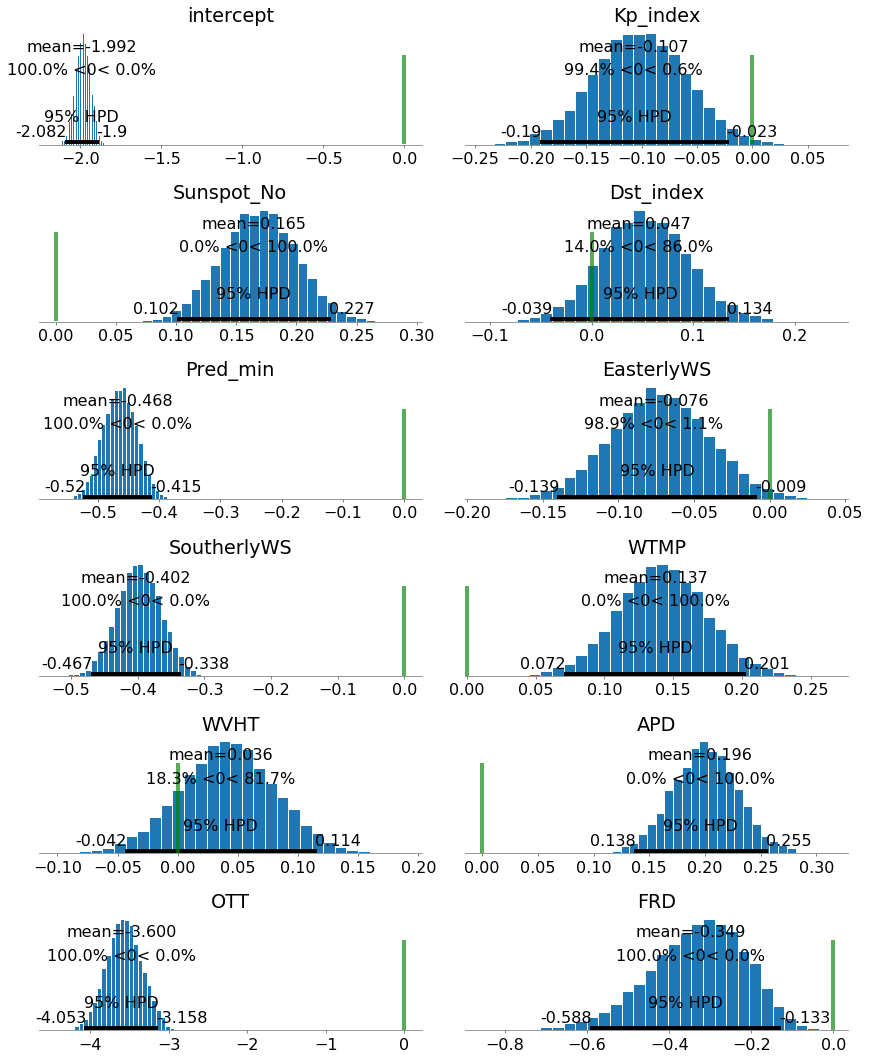

In [35]:
ax = pm.plot_posterior(trace_m1, ref_val=0)
for axi, flbl in zip(ax[1:].ravel(), dfClFeats_decorr.columns.tolist()[2:]):
    axi.set_title(flbl)
f = pl.gcf()
f.savefig('../FigJar/Poisson_all_m1.png', format='png', dpi=300)

In [45]:
ppc = pm.sample_ppc(trace_m1, samples=5000, model=m1)
y_pred_m1 = np.median(ppc['y_pred'], axis=0)

100%|██████████| 5000/5000 [00:04<00:00, 1067.50it/s]


In [48]:
x_obs, count_obs = np.unique(y_all_obs, return_counts=True)
x_pred_m1, count_pred_m1 = np.unique(y_pred_m1, return_counts=True)

(0, 50)

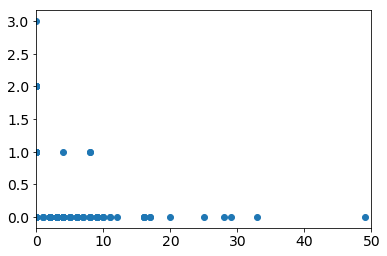

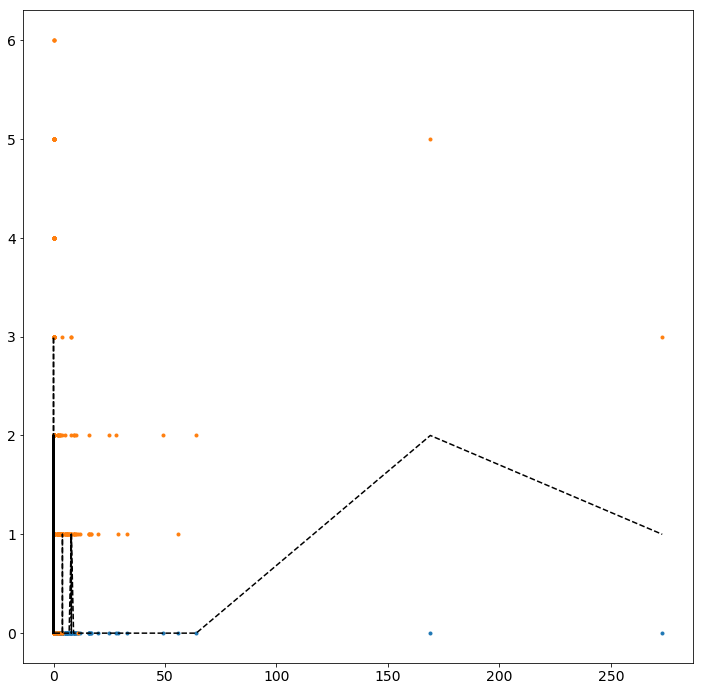

In [39]:
f, ax = pl.subplots( figsize=(12, 12))
ax.plot(y_all_obs[idx], sig95[idx,0], marker='.', ls='')
ax.plot(y_all_obs[idx], sig95[idx,1], marker='.', ls='')
ax.plot(y_all_obs[idx], med_y_pred[idx], 'k--')

logp = -6,032.3, ||grad|| = 1.636: 100%|██████████| 27/27 [00:00<00:00, 489.43it/s]   
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 10500/10500 [01:09<00:00, 150.34it/s]


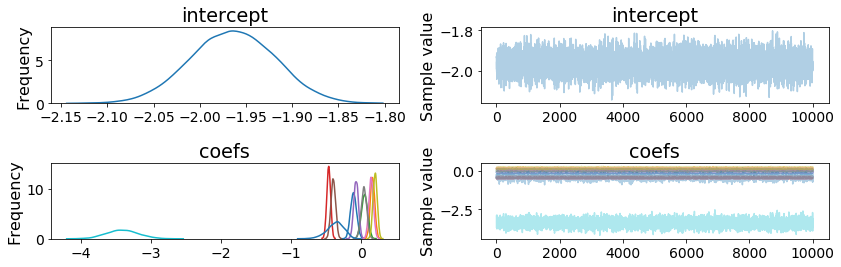

In [40]:
with pm.Model() as m2:
    intercept = pm.Normal('intercept', 0, 1)
    coefs = pm.Normal('coefs', 0, 1, shape=Xdc_all_sp_s.shape[1])
    mu = tt.exp(pm.math.dot(coefs, Xdc_all_sp_s.T) + intercept)
    y_pred = pm.Poisson('y_pred', mu=mu, observed=y_all_obs)
    start = pm.find_MAP()
    trace_m2 = pm.sample(10000, start=start)

pm.traceplot(trace_m2);

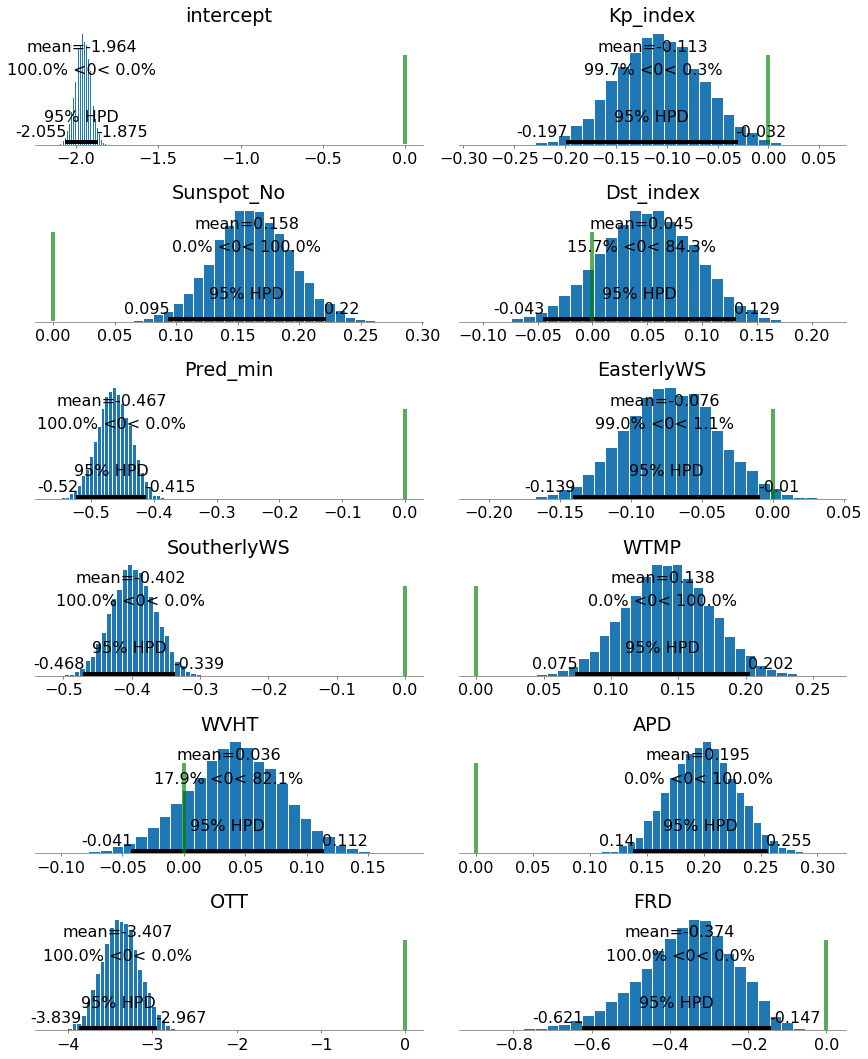

In [41]:
ax = pm.plot_posterior(trace_m2, ref_val=0)
for axi, flbl in zip(ax[1:].ravel(), dfClFeats_decorr.columns.tolist()[2:]):
    axi.set_title(flbl)
f = pl.gcf()
f.savefig('../FigJar/Poisson_all_m2_reg.png', format='png', dpi=300)

100%|██████████| 5000/5000 [00:04<00:00, 1079.05it/s]


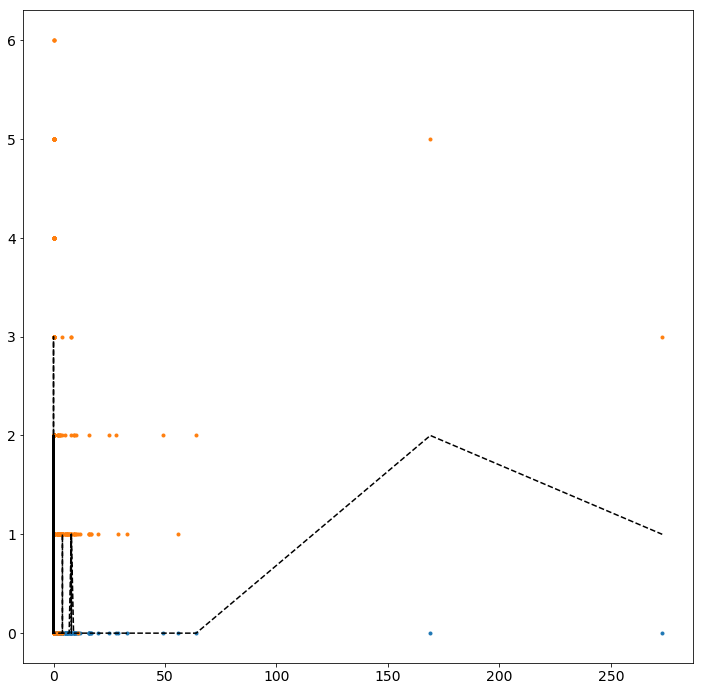

In [42]:
ppc_m2 = pm.sample_ppc(trace_m2, samples=5000, model=m2)
sig95_m2 = pm.hpd(ppc['y_pred'])
med_y_pred_m2 = np.median(ppc_m2['y_pred'], axis=0)
f, ax = pl.subplots( figsize=(12, 12))
ax.plot(y_all_obs[idx], sig95_m2[idx,0], marker='.', ls='')
ax.plot(y_all_obs[idx], sig95_m2[idx,1], marker='.', ls='')
ax.plot(y_all_obs[idx], med_y_pred_m2[idx], 'k--')

logp = -6,039.5, ||grad|| = 5.9335: 100%|██████████| 29/29 [00:00<00:00, 506.70it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 10500/10500 [01:08<00:00, 153.81it/s]


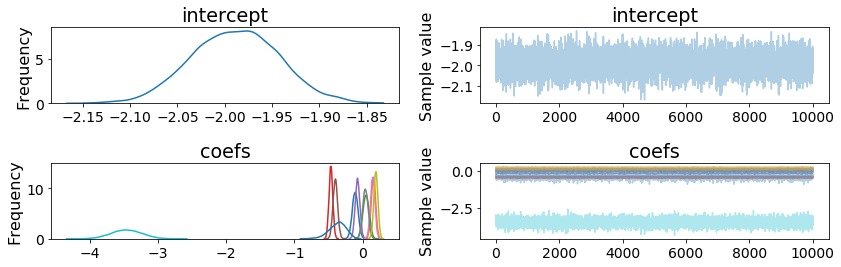

In [157]:
with pm.Model() as m3:
    intercept = pm.Normal('intercept', 0, 1)
    coefs = pm.Normal('coefs', 0, 1, shape=11)
    mu = tt.exp(pm.math.dot(coefs, Xdc_all_sp_s.T) + intercept)
    y_pred = pm.Poisson('y_pred', mu=mu, observed=y_all_obs)
    start = pm.find_MAP()
    trace_m3 = pm.sample(10000, start=start)
pm.traceplot(trace_m3);

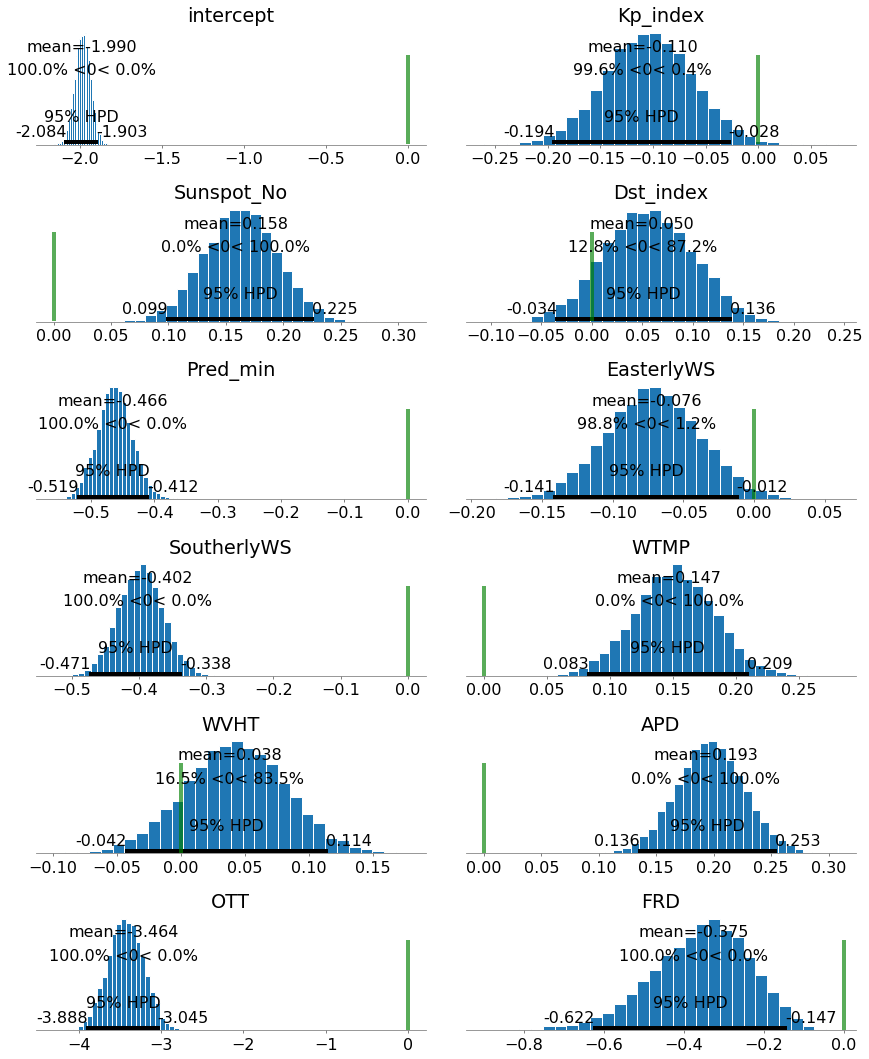

In [158]:
ax = pm.plot_posterior(trace_m3, ref_val=0)
for axi, flbl in zip(ax[1:].ravel(), dfClFeats_decorr.columns.tolist()[2:]):
    axi.set_title(flbl)
f = pl.gcf()
f.savefig('../FigJar/Poisson_all_m3_reg.png', format='png', dpi=300)

100%|██████████| 5000/5000 [00:04<00:00, 1054.98it/s]


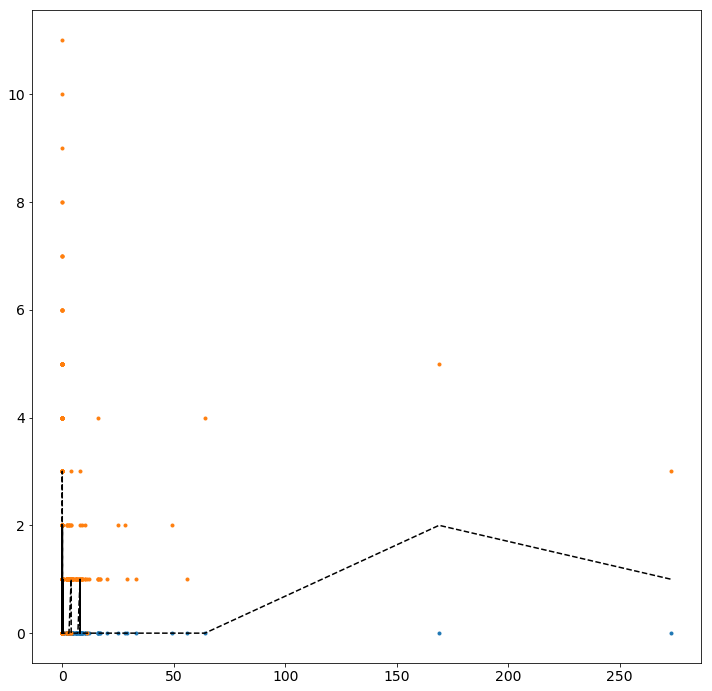

In [163]:
ppc_m3 = pm.sample_ppc(trace_m3, samples=5000, model=m3)
sig95_m3 = pm.hpd(ppc['y_pred'])
med_y_pred_m3 = np.median(ppc_m3['y_pred'], axis=0)
f, ax = pl.subplots( figsize=(12, 12))
ax.plot(y_all_obs[idx], sig95_m3[idx,0], marker='.', ls='')
ax.plot(y_all_obs[idx], sig95_m3[idx,1], marker='.', ls='')
ax.plot(y_all_obs[idx], med_y_pred_m3[idx], 'k--')

In [165]:
dfcomp = pm.compare([trace_m0, trace_m1, trace_m2, trace_m3], models=[m0, m1, m2, m3])
dfcomp.index = [['m0', 'm1', 'm2', 'm3'][i] for i in dfcomp.index]
dfcomp

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
m2,12927.3,791.25,0,NaN,3439.89,0,1
m1,12941.7,797.99,14.4,NaN,3451.59,15.71,1
m3,13021.4,677.61,94.14,NaN,3490.14,161.61,1
m0,13174,91.84,246.75,NaN,3961.48,594.58,1


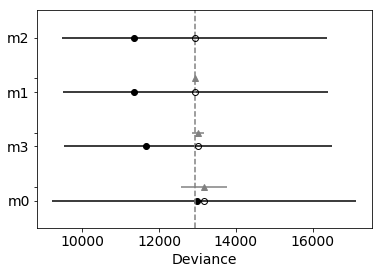

In [166]:
pm.compareplot(dfcomp)

In [171]:
# Pickle Models and traces for later use:
Models={'M0': {'model': m0, 'trace': trace_m0},
        'M1': {'model': m1, 'trace': trace_m1},
        'M2': {'model': m2, 'trace': trace_m2},
        'M3': {'model': m3, 'trace': trace_m3}
       }

In [173]:
with open('../PklJar/BayesModels_m0_m3.pkl', 'wb') as f:
    pickle.dump(Models, f)

logp = -6,179.3, ||grad|| = 0.31531: 100%|██████████| 25/25 [00:00<00:00, 322.54it/s]  
100%|██████████| 11000/11000 [02:15<00:00, 80.93it/s]


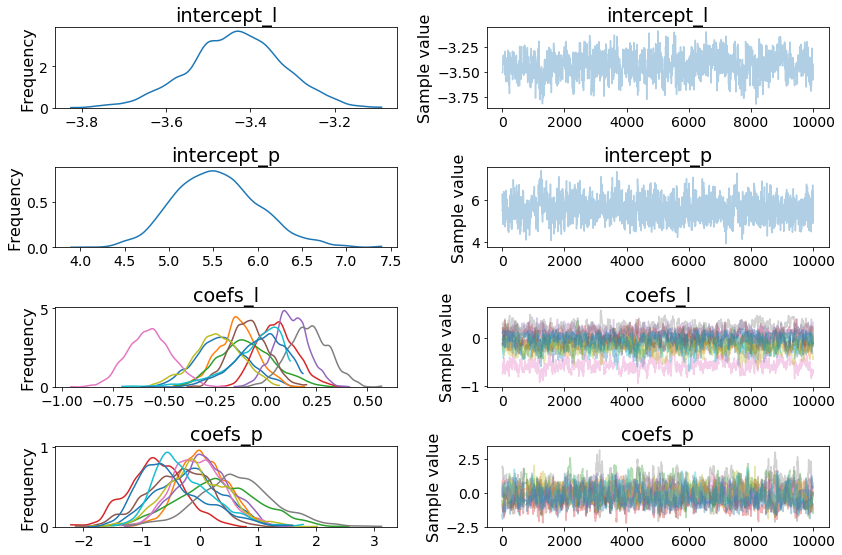

In [177]:
with pm.Model() as m4:
    intercept_l = pm.Normal('intercept_l', 0, 1)
    intercept_p = pm.Normal('intercept_p', 0, 1)
    coefs_l = pm.Normal('coefs_l', 0, 1, shape=11)
    coefs_p = pm.Normal('coefs_p', 0, 1, shape=11)
    mu_l = tt.exp(pm.math.dot(coefs_l,
                              Xdc_all_sp_s.T) + intercept_l)
    p = pm.invlogit(pm.math.dot(coefs_p,
                                   Xdc_all_sp_s.T) + intercept_p)
    y_pred = pm.ZeroInflatedPoisson('y_pred', mu_l, p,
                                   observed=y_all_obs)
    #y_pred = pm.Poisson('y_pred', mu=mu, observed=y_all_obs)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace_m4 = pm.sample(10000, start=start, step=step, tune=1000)
pm.traceplot(trace_m4);

100%|██████████| 5000/5000 [00:08<00:00, 575.95it/s]


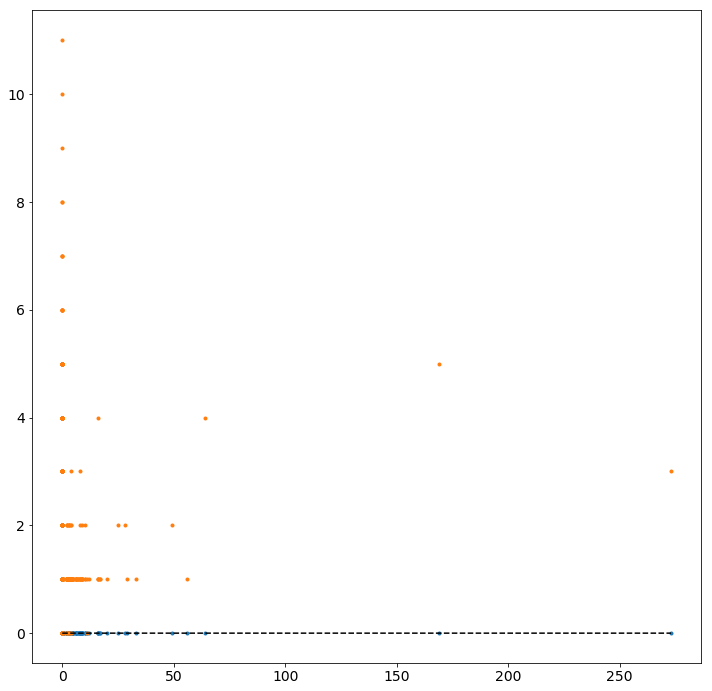

In [178]:
ppc_m4 = pm.sample_ppc(trace_m4, samples=5000, model=m4)
sig95_m4 = pm.hpd(ppc['y_pred'])
med_y_pred_m4 = np.median(ppc_m4['y_pred'], axis=0)
f, ax = pl.subplots( figsize=(12, 12))
ax.plot(y_all_obs[idx], sig95_m4[idx,0], marker='.', ls='')
ax.plot(y_all_obs[idx], sig95_m4[idx,1], marker='.', ls='')
ax.plot(y_all_obs[idx], med_y_pred_m4[idx], 'k--')